## Knjižnice in spremenljivke


In [1]:
import pandas as pd
import folium as f
from datetime import datetime
import collections
import matplotlib.pyplot as plt
import plotly.express as px
from dateutil.relativedelta import relativedelta
import seaborn as sns
%store -r comm_data
%store -r cars
%store -r population
plt.style.use('seaborn')

C:\Users\oskar\AppData\Local\Temp\ipykernel_13652\670603438.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Porazdelitev avtov na leto


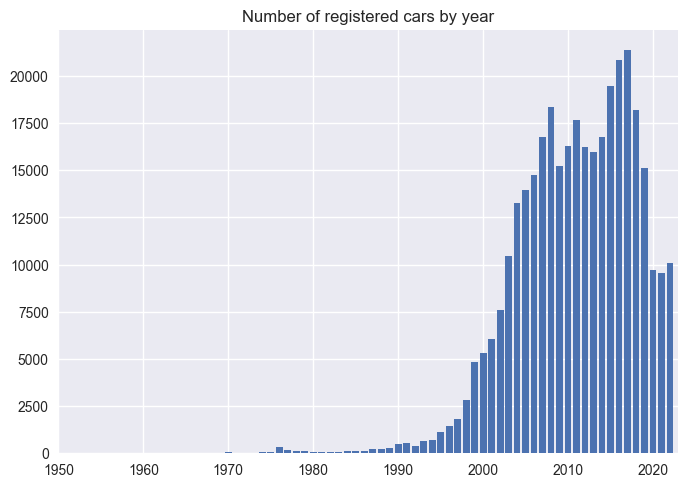

In [2]:
years = list([datetime.strptime(x, '%d.%m.%Y').year for x in cars['B-Datum prve registracije vozila']])
years = filter(lambda x: x>=1950,years)
years = collections.Counter(years)
years = dict(sorted(years.items(), reverse=True))
""" adj_values = [x/population.iloc[y-1950,1] for x,y in zip(years.values(),years.keys())]
plt.bar(years.keys(),adj_values)

# Set the plot title and axis labels
plt.title('Number of registered vehicles per year')
plt.xlabel('Count')
"""

plt.show()
plt.bar(years.keys(),years.values())
plt.xlim(1950,2023)
plt.title('Number of registered cars by year')

plt.show()

In [3]:
import plotly.graph_objects as go

# Prepare the data for the stacked area chart
registration_dates = pd.to_datetime(cars['B-Datum prve registracije vozila'], format='%d.%m.%Y')
registration_years = registration_dates.dt.year

years = filter(lambda x: x >= 1950, registration_years)
years = collections.Counter(years)
years = dict(sorted(years.items()))

cumulative_counts = []
cumulative_count = 0
for year, count in years.items():
    cumulative_count += count
    cumulative_counts.append(cumulative_count)

# Reverse the order of cumulative counts
cumulative_counts = cumulative_counts[::-1]

# Reverse the order of years
years = list(years.keys())[::-1]

# Create the stacked area chart
fig = go.Figure(data=[go.Scatter(x=years, y=cumulative_counts, mode='lines', stackgroup='one')])

# Customize the chart layout
fig.update_layout(
    title='Cumulative Count of Registered Cars Over Time',
    xaxis_title='Registration Date',
    yaxis_title='Cumulative Count',
)

# Show the stacked area chart
fig.show()


### Najpopularnejša znamka


In [4]:
car_brands = {
    "VOLKSWAGEN": "Nemčija",
    "OPEL": "Nemčija",
    "FORD": "Združene države",
    "BMW": "Nemčija",
    "MERCEDES BENZ": "Nemčija",
    "AUDI": "Nemčija",
    "RENAULT": "Francija",
    "CITROEN": "Francija",
    "PEUGEOT": "Francija",
    "ŠKODA": "Češka republika",
    "FIAT": "Italija",
    "KIA": "Južna Koreja",
    "HYUNDAI": "Južna Koreja",
    "SEAT": "Španija",
    "VOLVO": "Švedska",
    "DACIA": "Romunija",
    "NISSAN": "Japonska",
    "MAZDA": "Japonska",
    "TOYOTA": "Japonska",
    "SUZUKI": "Japonska",
    "HONDA": "Japonska",
}

In [5]:
brand = collections.Counter(cars['D1-Znamka'])
# Convert the dictionary to a DataFrame
df = pd.DataFrame({'brand': list(brand.keys()), 'value': list(brand.values())})

# Compute the total value of all brands
total_value = df['value'].sum()
# Compute the percentage of each brand
df['country'] = df['brand'].map(car_brands).fillna("Preostale države")
sum_other = df.loc[df['country'] == 'Preostale države','value'].sum()
df = df[df['country'] != 'Preostale države'].copy()

new_row = [{'brand': 'Preostale znamke', 'value': sum_other,'country':'Drugo'}]
df = pd.concat([df, pd.DataFrame(new_row)], ignore_index=True)
df['percent'] = (df['value'] / total_value) * 100


# Create the hover text to display in each rectangle
df['text'] = df['brand'] + '<br>' + df['percent'].round(2).astype(str) + '%'
# Set the Seaborn color palette
colors = sns.color_palette('husl', n_colors=len(df))
# Convert the RGB colors to Plotly color strings
color_strings = ['rgb({},{},{})'.format(int(c[0]*255), int(c[1]*255), int(c[2]*255)) for c in colors]
# Create the treemap using Plotly
fig = px.treemap(df, path=[ 'country','text'], values='value')

fig.update_layout(dict( height=800))
fig.show()

### Delež goriv na leto 

In [47]:
import plotly.graph_objects as go

cars['B-Datum prve registracije vozila'] = pd.to_datetime(cars['B-Datum prve registracije vozila'], format='%d.%m.%Y')
cars['P13-Vrsta goriva (opis)'].replace('Ni goriva', 'Elektrika')

years_fuel_dict = dict()
gasoline_ratios= list()
diesel_ratios= list()
electricity_ratios= list()
for y in range(1975, 2022):
    car_fuel = cars[cars['B-Datum prve registracije vozila'].dt.year == y]
    car_fuel = collections.Counter(car_fuel['P13-Vrsta goriva (opis)'])
    for key in ['Bencin', 'Dizel', 'Ni goriva']:
        if key is None or key not in car_fuel:
            car_fuel[key] = 0;
    total = car_fuel['Bencin']+ car_fuel['Dizel']+ car_fuel['Ni goriva'];
    gasoline_ratios.append(car_fuel['Bencin']/total*100)
    diesel_ratios.append(car_fuel['Dizel']/total*100)
    electricity_ratios.append(car_fuel['Ni goriva']/total*100)
    years_fuel_dict[y]= [car_fuel['Bencin']/total*100, car_fuel['Dizel']/total*100, car_fuel['Ni goriva']/total*100]



trace1 = go.Bar(x=list(years_fuel_dict.keys()), y=gasoline_ratios, name='Benzin')
trace2 = go.Bar(x=list(years_fuel_dict.keys()), y=diesel_ratios, name='Dizel')
trace3 = go.Bar(x=list(years_fuel_dict.keys()), y=electricity_ratios, name='Elektrika')

layout = go.Layout(
    title='Car fuel percentages by year',
    barmode='stack',
    xaxis=dict(
        tickmode='array',
        tickvals=list(years_fuel_dict.keys()).  ,
        ticktext=[str(year) + ' ' * 8 for year in years_fuel_dict.keys()]  # Adjust the spacing as needed
    ),

    margin=dict(
        l=80,  # Adjust the left margin value as needed
        r=50,
        b=50,
        t=80,
        pad=4
    )
)

# Create the figure
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)

# Show the figure
fig.show()
